In [610]:
import tensorflow as tf
import numpy as np
import gym
import gym.spaces
from pylab import *
import scipy.misc

In [2]:
%matplotlib notebook

In [3]:
G = 0.9
N_ACTIONS = 9
ACTIONS = np.arange(N_ACTIONS)

## Network setup

In [754]:
tf.reset_default_graph()
sess = tf.Session()

# TODO: Xavier initialisers

graph_r = tf.placeholder(tf.float32, [None])
graph_lr = tf.Variable(1e-4)
graph_s = tf.placeholder(tf.float32, [None, 84, 84, 4])
graph_action = tf.placeholder(tf.int64, [None])
graph_advantage = tf.placeholder(tf.float32, [None])

x = tf.layers.conv2d(
        inputs=graph_s,
        filters=32,
        kernel_size=8,
        strides=4,
        activation=tf.nn.relu)

x = tf.layers.conv2d(
        inputs=x,
        filters=64,
        kernel_size=4,
        strides=2,
        activation=tf.nn.relu)

x = tf.layers.conv2d(
        inputs=x,
        filters=64,
        kernel_size=3,
        strides=1,
        activation=tf.nn.relu)

w, h, f = x.shape[1:]
x = tf.reshape(x, [-1, int(w * h * f)])

x = tf.layers.dense(
        inputs=x,
        units=512,
        activation=tf.nn.relu)

a_logits = tf.layers.dense(
        inputs=x,
        units=N_ACTIONS,
        activation=None)

a_softmax = tf.nn.softmax(a_logits)

graph_v = tf.layers.dense(
    inputs=x,
    units=1,
    activation=None)
graph_v = graph_v[:, 0]

p = 0
for i in range(N_ACTIONS):
    p += tf.cast(tf.equal(graph_action, i), tf.float32) * a_softmax[:, i]
nlp = -1 * tf.log(p)
loss = tf.reduce_mean(nlp * graph_advantage)    
t = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

# TODO: reduce_mean or reduce_sum?
loss2 = tf.reduce_mean((graph_r - graph_v) ** 2)
t2 = tf.train.AdamOptimizer(learning_rate=graph_lr).minimize(loss2)

## Action probability selection test

In [461]:
sess.run(tf.global_variables_initializer())
s = np.random.random((1, 84, 84, 4))
s = np.vstack([s] * N_ACTIONS)
expected = -1 * np.log(sess.run(a_softmax, feed_dict={graph_s: s})[0])
actual = sess.run(nlp, feed_dict={graph_s: s, graph_action: np.arange(N_ACTIONS)})
np.testing.assert_allclose(expected, actual)

## Basic policy network training test

In [462]:
sess.run(tf.global_variables_initializer())
n = 5
s = np.random.random((1, 84, 84, 4))
s = np.vstack([s] * n)

print(sess.run(a_softmax, feed_dict={graph_s: s})[0])
a = [0] * n
ad = [1] * n
for i in range(3):
    sess.run(t, feed_dict={graph_s: s, graph_action: a, graph_advantage: ad})
    print(sess.run(a_softmax, feed_dict={graph_s: s})[0])
# now the probability of action[0] will be very close to 1,
# so the gradients will be too small to work
# so reset
sess.run(tf.global_variables_initializer())
print()
print(sess.run(a_softmax, feed_dict={graph_s: s})[0])
a = [0] * n
ad = [-1] * n
for i in range(3):
    sess.run(t, feed_dict={graph_s: s, graph_action: a, graph_advantage: ad})
    print(sess.run(a_softmax, feed_dict={graph_s: s})[0])

[ 0.10848492  0.11034466  0.12670109  0.09328968  0.10463993  0.10683646
  0.10637622  0.11041979  0.13290717]
[ 0.13351598  0.10380731  0.12250793  0.09152929  0.10391526  0.10328127
  0.1042342   0.10853054  0.12867832]
[ 0.16180326  0.09721972  0.11870607  0.08919366  0.10227831  0.09874429
  0.10130129  0.1062222   0.12453128]
[ 0.19548681  0.09054251  0.11491486  0.08647115  0.09997077  0.09356444
  0.09710278  0.10331546  0.11863115]

[ 0.10616729  0.1070467   0.10883211  0.10444742  0.12317429  0.12239089
  0.11449856  0.10308765  0.11035509]
[ 0.08857553  0.11086352  0.10976861  0.10469551  0.12524326  0.12662691
  0.11535983  0.10677321  0.11209368]
[ 0.07339845  0.11418556  0.11005178  0.10413864  0.12768351  0.13081793
  0.11639562  0.1103394   0.11298914]
[ 0.05945676  0.117672    0.11068442  0.10322943  0.13025348  0.13469502
  0.11736766  0.11374114  0.11290003]


## Basic value network training test

In [539]:
s = np.random.normal(size=(5, 84, 84, 4))
r = np.array([1, 2, 3, 4, 5]) / 5.0
print(r)
sess.run(tf.global_variables_initializer())
sess.run(graph_v, feed_dict={graph_s: s})

[ 0.2  0.4  0.6  0.8  1. ]


array([-0.25281048, -0.16718042, -0.33672947, -0.19710909, -0.30827755], dtype=float32)

In [608]:
sess.run(t2, feed_dict={graph_s: s, graph_r: r})
sess.run([loss2, graph_v], feed_dict={graph_s: s, graph_r: r})

[5.6838653e-05,
 array([ 0.1950734 ,  0.39835683,  0.6061551 ,  0.80783087,  1.01257038], dtype=float32)]

## Utils

In [763]:
def copy_network():
    n1_dict = {var.name: var for var in tf.trainable_variables() if 'network1' in var.name}
    n2_dict = {var.name: var for var in tf.trainable_variables() if 'network2' in var.name}
    copy_ops = []
    for name, var in n2_dict.items():
        op = var.assign(n1_dict[name.replace('network2', 'network1')].value())
        copy_ops.append(op)
    sess.run(copy_ops)
    
def with_prob(p):
    if np.random.random() < p:
        return True
    else:
        return False

def discount_rewards(r, G):
    r2 = np.zeros_like(np.array(r).astype(np.float32))
    r2[-1] = r[-1]
    for i in range(len(r2)-2, -1, -1):
        r2[i] = G * r2[i+1]
    return r2

def rewards_to_returns(r, G):
    r2 = np.zeros_like(np.array(r).astype(np.float32))
    r2[-1] = r[-1]
    for i in range(len(r2)-2, -1, -1):
        r2[i] = r[i] + G * r2[i+1]
    return r2

In [765]:
print(discount_rewards([0, 0, 0, 1], 0.9))
print(rewards_to_returns([1, 2, 3, 4], 0.9))

[ 0.72899997  0.81        0.89999998  1.        ]
[ 8.14599991  7.94000006  6.5999999   4.        ]


## Dummy environment

In [741]:
class DummyEnv:
    action_space = gym.spaces.discrete.Discrete(2)
    N_STATES = 3
    N_REWARDED_SEQUENCES = int(N_ACTIONS ** N_STATES / 10)
    
    def __init__(self):
        self.rewarded_sequences = np.clip(np.random.normal(loc=int(N_ACTIONS / 2), size=(self.N_REWARDED_SEQUENCES, self.N_STATES)).astype(np.int), 0, N_ACTIONS)
        self.rewarded_sequences = np.unique(self.rewarded_sequences, axis=0)
        self.o = {}
        # look at all unique sequence prefixes
        for i in range(1, self.N_STATES + 1):
            prefixes = np.unique(env.rewarded_sequences[:, :i], axis=0)
            for p in prefixes:
                self.o[tuple(p)] = np.random.normal(size=(84, 84, 4))
        self.default_o = np.random.normal(size=(84, 84, 4))
        self.init_o = np.random.normal(size=(84, 84, 4))
    
    def reset(self):
        self.i = 0
        self.history = []
        self.possible_sequences = np.copy(self.rewarded_sequences)
        return self.init_o
    
    def step(self, a):
        self.history.append(a)
        
        ps_new = []
        l = len(self.history)
        for seq in self.possible_sequences:
            if np.array_equal(seq[:l], self.history):
                ps_new.append(seq)
        self.possible_sequences = ps_new
        if len(self.possible_sequences) > 0:
            reward = 1
        else:
            reward = 0
            
        if tuple(self.history) in self.o:
            o = self.o[tuple(self.history)]
        else:
            o = self.default_o

        if self.i != self.N_STATES - 1:
            done = False
            self.i += 1
        else:
            done = True

        return o, reward, done, None

In [742]:
env = DummyEnv()

In [743]:
for i in range(N_ACTIONS):
    env.reset()
    env.step(i)
    print(len(env.possible_sequences))

0
2
5
11
11
7
3
0
0


In [744]:
# Initial state same?
o = env.reset()
print(np.sum(o))
o = env.reset()
print(np.sum(o))

-225.519265304
-225.519265304


In [745]:
# Default state the same?
env.reset()
o, _, _, _ = env.step(0)
print(np.sum(o))
env.reset()
o, _, _, _ = env.step(8)
print(np.sum(o))

37.8046131907
37.8046131907


In [747]:
# Always the same state returned for a given sequence?
env.reset()
o, _, _, _ = env.step(5)
print(np.sum(o))
env.reset()
o, _, _, _ = env.step(5)
print(np.sum(o))

env.reset()
env.step(5)
o, _, _, _ = env.step(5)
print(np.sum(o))
env.reset()
env.step(5)
o, _, _, _ = env.step(5)
print(np.sum(o))

-136.684018484
-136.684018484
-223.833923894
-223.833923894


In [749]:
def test_seq(seq):
    for a in seq:
        print("Took action", a)
        _, reward, done, _ = env.step(a)
        print("Got reward ", reward)
        print("Done:", done)

env.reset()
test_seq([0, 0, 0])
print()
env.reset()
test_seq(env.rewarded_sequences[0])

Took action 0
Got reward  0
Done: False
Took action 0
Got reward  0
Done: False
Took action 0
Got reward  0
Done: True

Took action 1
Got reward  1
Done: False
Took action 3
Got reward  1
Done: False
Took action 3
Got reward  1
Done: True


## Testing proper

In [817]:
sess.run(tf.global_variables_initializer())

In [818]:
env = DummyEnv()

### Manual testing

In [456]:
sess.run(t, feed_dict={graph_s: [env.o[2]], graph_action: [1], graph_advantage: [1]})
sess.run(a_softmax, feed_dict={graph_s: env.o})

array([[ 0.39359078,  0.60640925],
       [ 0.31771442,  0.68228555],
       [ 0.24010767,  0.75989234],
       [ 0.32243866,  0.67756128],
       [ 0.35887474,  0.64112526]], dtype=float32)

### Testing with environment

In [819]:
rpe = [0]

In [820]:
for i in range(100):
    o = env.reset()
    done = False
    rewards = []
    actions = []
    states = []
    s2 = []
    while not done:
        states.append(o)
        s2.append(np.sum(o))
        a_p = sess.run(a_softmax, feed_dict={graph_s: [o]})[0]
        a = np.random.choice(ACTIONS, p=a_p)
        actions.append(a)
        o, r, done, _ = env.step(a)
        rewards.append(r)
    
    if np.sum(rewards) == 3:
        print(actions)
    rpe.append(rpe[-1] + 0.1 * (np.sum(rewards) - rpe[-1]))
    
    returns = rewards_to_returns(rewards, G=1.0)
    sess.run([t, t2], feed_dict={graph_s: states, graph_action: actions, graph_advantage: returns, graph_r: returns})

[4, 5, 3]
[5, 5, 4]
[5, 3, 6]
[5, 5, 2]
[4, 5, 5]
[5, 5, 2]
[5, 5, 4]
[5, 5, 4]
[5, 5, 4]
[5, 5, 2]
[5, 5, 2]
[5, 5, 4]
[5, 5, 4]
[5, 5, 2]
[4, 5, 5]
[5, 5, 2]
[5, 5, 2]
[5, 5, 4]
[5, 5, 2]
[5, 5, 4]
[5, 5, 2]
[4, 5, 5]
[5, 5, 4]
[5, 5, 2]
[5, 5, 4]
[4, 5, 5]
[4, 4, 5]
[5, 5, 4]
[4, 5, 5]
[4, 5, 5]
[5, 5, 2]
[4, 4, 4]
[4, 4, 4]
[4, 5, 5]
[5, 4, 4]
[5, 4, 4]
[4, 4, 4]
[4, 5, 5]
[5, 5, 4]
[5, 4, 4]
[4, 4, 5]
[5, 4, 4]
[4, 4, 4]
[5, 5, 2]
[5, 5, 4]


In [821]:
for i in range(N_ACTIONS):
    env.reset()
    o, _, _, _ = env.step(i)
    print(sess.run(graph_v, feed_dict={graph_s: [o]}))

[ 0.37581575]
[ 1.20092607]
[ 1.11531639]
[ 1.09899306]
[ 1.73032939]
[ 1.48543942]
[ 0.67292488]
[ 0.37581575]
[ 0.37581575]


<IPython.core.display.Javascript object>


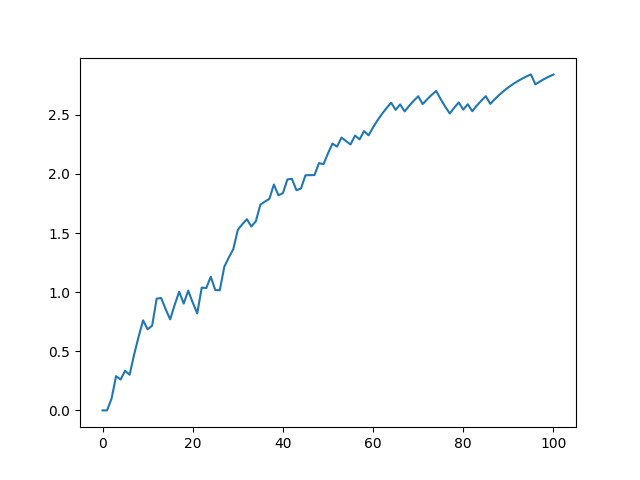

In [822]:
plt.plot(rpe)

## Old code

In [131]:
t = 0
t_max = 100

s = np.zeros(10)
r1 = np.zeros(10)
a = np.zeros(10)
r2_list = []

for i in range(10):
    t_start = t
    s[t] = env.reset()
    done = False
    
    while True:
        a_p = sess.run(ap_op, feed_dict={s_op: s})
        a[t] = np.random.choice(ACTIONS, p=a_p)
        s[t+1], r[t], done, _ = env.step(a[t])
        t += 1        
    if done or t - t_start == t_max:
        break
    
    if done:
        r2 = 0
    else:
        r2 = sess.run(v_op, feed_dict={s_op: s[t]})
    
    for i in range(t-1, t_start-1, -1):
        r2_list.append(r[i] + g * r2)
    
    
    sess.run(t1, feed_dict={s_op: s, big_r_op: r})
    sess.run(t2, feed_dict={s_op: s, big_r_op: r})

0
0
0
0
0
0
0
0
0
0


In [110]:
observation.shape
action = env.action_space.sample()
os = []
for i in range(4):
    o1, _, _, _ = env.step(action)
    o2, _, _, _ = env.step(action)
    o = np.maximum(o1, o2)
    o = np.mean(o, axis=2)
    o = scipy.misc.imresize(o, (84, 84))
    os.append(o)
os = np.stack(os, axis=-1)

In [80]:
os = np.resize(os, (1, 84, 84, 4))
print(os.shape)
print(sess.run(q['network1'], feed_dict={s: os}))
print(sess.run(qi['network1'], feed_dict={s: os}))

(1, 84, 84, 4)
[[  0.69894785  -0.22462213   5.59576368  -7.67884588  16.15483665
    2.82746601   0.95167667   5.31193829   0.30126441]]
[ 16.15483665]
[4]
